# Testing the CosmoAPI SACC Generation Developement

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from firecrown.metadata_types import Galaxies, InferredGalaxyZDist, TwoPointHarmonic
from firecrown.generators.inferred_galaxy_zdist import ZDistLSSTSRDBin, LinearGrid1D
from firecrown.utils import base_model_to_yaml, base_model_from_yaml
from firecrown.metadata_functions import make_all_photoz_bin_combinations, TwoPointHarmonic, TwoPointReal
import firecrown.likelihood.two_point as tp
from firecrown.modeling_tools import ModelingTools
from firecrown.ccl_factory import CCLFactory
from firecrown.updatable import get_default_params
from firecrown.parameters import ParamsMap
import firecrown

import numpy as np
import matplotlib.pyplot as plt
import importlib
import sys

# this is only needed for now:
from CosmoAPI.two_pt_func import generate_theory, nz_loader, tracer_tools
from CosmoAPI.api_io import load_yaml_file

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: cannot import name 'tracers_io' from 'CosmoAPI.two_pt_func' (unknown location)

In [2]:
config = load_yaml_file('../test.yaml')
#config = load_yaml_file('../example_yamls/twopcf_generator.yaml')

In [3]:
ell_test = generate_theory.generate_ell_theta_array_from_yaml(config['probes']['source'], 'ell_bins', dtype=float)
print(len(ell_test))

128


In [4]:
#FIXME: We have to implement this in the yaml
ells = np.unique(np.geomspace(2, 2000, 128).astype(int))
print(ells)

[   2    3    4    5    6    7    8    9   10   11   12   13   14   15
   16   17   18   19   20   21   23   24   25   27   28   30   32   33
   35   37   39   42   44   46   49   52   55   58   61   64   68   72
   76   80   85   90   95  100  106  111  118  124  131  139  146  155
  163  172  182  192  203  215  227  239  253  267  282  298  314  332
  350  370  391  413  436  460  486  513  542  572  604  638  673  711
  751  793  837  884  933  986 1041 1099 1160 1225 1294 1366 1443 1523
 1608 1698 1793 1894 2000]


In [5]:
#FIXME: We have to implement this in the yaml
ells = np.unique(np.geomspace(2, 2000, 128))

# process the probes:
two_pt_function, two_pt_probes = tracers_io.process_probes_load_2pt(config)
# load all the nzs:
nzs = nz_loader.load_all_redshift_distr(config)

# make all two point functions bin combinations:
all_two_point_bins = make_all_photoz_bin_combinations(nzs)
# generate the necessary metadata:
all_two_point_metdata = [two_pt_function(XY=ij, ells=ells) for ij in all_two_point_bins]

# load all the systematics for all probes:
probes = config.get("probes", [])
for p in two_pt_probes:
    probes[p]['loaded_systematics'] = generate_theory.load_systematics_factory(config['probes'][p]['systematics'])

# prepare all the two point functions:
all_two_point_functions = tp.TwoPoint.from_metadata(
    metadata_seq=all_two_point_metdata,
    wl_factory=probes['source']['loaded_systematics'],
    nc_factory=probes['lens']['loaded_systematics'],
)

All nz_type probes have the same function: TwoPointHarmonic
All nz_type probes have the same function: TwoPointHarmonic


In [6]:
two_pt_function == TwoPointHarmonic

True

In [6]:
type(probes['source']['loaded_systematics'])

firecrown.likelihood.weak_lensing.WeakLensingFactory

In [7]:
generate_theory.prepare_2pt_functions(config)

All nz_type probes have the same function: TwoPointHarmonic
All nz_type probes have the same function: TwoPointHarmonic


(UpdatableCollection([<firecrown.likelihood.two_point.TwoPoint at 0x135b7eb70>,
                      <firecrown.likelihood.two_point.TwoPoint at 0x135b7f080>]),
 [TwoPointHarmonic(XY=TwoPointXY(x=InferredGalaxyZDist(bin_name='source_0', z=array([1.00000000e-04, 1.21361694e-04, 1.42723389e-04, 1.64085083e-04,
         1.85446777e-04, 2.28170166e-04, 2.70893555e-04, 3.56340332e-04,
         4.41787109e-04, 5.27233887e-04, 6.12680664e-04, 6.98127441e-04,
         7.83574219e-04, 9.54467773e-04, 1.12536133e-03, 1.29625488e-03,
         1.46714844e-03, 1.80893555e-03, 2.15072266e-03, 2.49250977e-03,
         2.83429687e-03, 3.51787109e-03, 4.20144531e-03, 4.88501953e-03,
         5.56859375e-03, 6.93574219e-03, 8.30289062e-03, 9.67003906e-03,
         1.10371875e-02, 1.24043359e-02, 1.37714844e-02, 1.51386328e-02,
         1.65057812e-02, 1.78729297e-02, 1.92400781e-02, 2.06072266e-02,
         2.19743750e-02, 2.47086719e-02, 2.74429687e-02, 3.01772656e-02,
         3.29115625e-02, 3.56458

In [8]:
two_pt_function is firecrown.metadata_types.TwoPointHarmonic

True

In [9]:
tools = ModelingTools(ccl_factory=CCLFactory(require_nonlinear_pk=True))
default_values = get_default_params(tools, all_two_point_functions)
params = ParamsMap(default_values)

tools.update(params)
tools.prepare()
all_two_point_functions.update(params)

In [10]:
default_values

{'h': 0.67,
 'lens_4_bias': 1.5,
 'source_0_mult_bias': 1.0,
 'alphaz': 0.0,
 'source_4_delta_z': 0.0,
 'lens_1_bias': 1.5,
 'lens_2_delta_z': 0.0,
 'w0': -1.0,
 'z_piv': 0.5,
 'lens_0_delta_z': 0.0,
 'source_3_delta_z': 0.0,
 'source_4_mult_bias': 1.0,
 'Omega_k': 0.0,
 'source_2_delta_z': 0.0,
 'lens_3_bias': 1.5,
 'T_CMB': 2.7255,
 'source_2_mult_bias': 1.0,
 'Omega_b': 0.05,
 'n_s': 0.96,
 'source_3_mult_bias': 1.0,
 'source_1_delta_z': 0.0,
 'lens_3_delta_z': 0.0,
 'Neff': 3.044,
 'Omega_c': 0.25,
 'sigma8': 0.81,
 'lens_2_bias': 1.5,
 'lens_1_delta_z': 0.0,
 'ia_bias': 0.5,
 'lens_4_delta_z': 0.0,
 'm_nu': [],
 'source_1_mult_bias': 1.0,
 'lens_0_bias': 1.5,
 'source_0_delta_z': 0.0,
 'wa': 0.0}

In [11]:
two_point0 = all_two_point_functions[0]
meta0 = all_two_point_metdata[0]
tv0 = two_point0.compute_theory_vector(tools)

In [12]:
import pandas as pd
two_point_pd_list = []
for two_point, meta in zip(all_two_point_functions, all_two_point_metdata):
    two_point_pd_list.append(
        pd.DataFrame(
            {
                "ell": two_point.ells,
                "Cell": np.abs(two_point.compute_theory_vector(tools)),
                "bin-x": meta.XY.x.bin_name,
                "bin-y": meta.XY.y.bin_name,
                "measurement": meta.get_sacc_name(),
            }
        )
    )

In [13]:
two_point_pd_list

[             ell          Cell     bin-x     bin-y         measurement
 0       2.000000  2.062488e-08  source_0  source_0  galaxy_shear_cl_ee
 1       2.111796  2.150840e-08  source_0  source_0  galaxy_shear_cl_ee
 2       2.229842  2.228341e-08  source_0  source_0  galaxy_shear_cl_ee
 3       2.354486  2.295176e-08  source_0  source_0  galaxy_shear_cl_ee
 4       2.486098  2.351573e-08  source_0  source_0  galaxy_shear_cl_ee
 ..           ...           ...       ...       ...                 ...
 123  1608.947253  2.188825e-11  source_0  source_0  galaxy_shear_cl_ee
 124  1698.884500  1.971539e-11  source_0  source_0  galaxy_shear_cl_ee
 125  1793.849076  1.773986e-11  source_0  source_0  galaxy_shear_cl_ee
 126  1894.122000  1.594651e-11  source_0  source_0  galaxy_shear_cl_ee
 127  2000.000000  1.432087e-11  source_0  source_0  galaxy_shear_cl_ee
 
 [128 rows x 5 columns],
              ell          Cell     bin-x     bin-y         measurement
 0       2.000000  2.918190e-08  sour

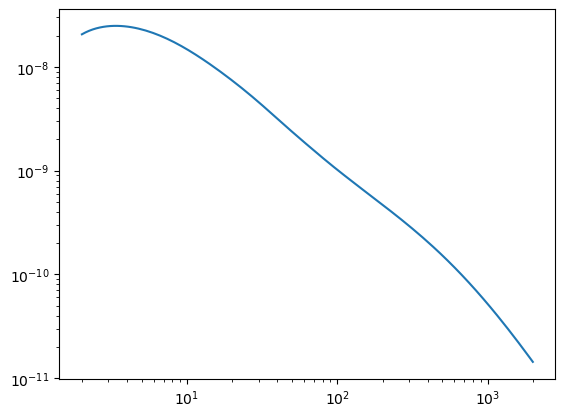

In [14]:
plt.loglog(ells, tv0)

In [15]:
ells

array([   2.        ,    2.11179639,    2.22984199,    2.35448614,
          2.48609766,    2.62506603,    2.77180248,    2.92674123,
          3.09034079,    3.26308526,    3.44548583,    3.63808227,
          3.8414445 ,    4.05617431,    4.28290713,    4.5223139 ,
          4.77510308,    5.04202273,    5.32386269,    5.621457  ,
          5.9356863 ,    6.26748045,    6.61782129,    6.98774555,
          7.37834791,    7.79078423,    8.22627501,    8.68610893,
          9.17164673,    9.68432522,   10.22566152,   10.79725753,
         11.40080474,   12.03808914,   12.71099658,   13.42151834,
         14.17175698,   14.96393261,   15.80038942,   16.68360267,
         17.61618593,   18.60089892,   19.64065558,   20.73853277,
         21.8977793 ,   23.12182563,   24.41429393,   25.77900888,
         27.22000893,   28.74155828,   30.3481595 ,   32.04456682,
         33.83580024,   35.72716038,   37.72424414,   39.83296128,
         42.05955189,   44.4106049 ,   46.89307753,   49.51431